# Preprocessing and Exploratory Visualization


## Raw data

The raw data file 'data/data_2017.csv' contains two comma-separated columns. The first is the (unicode) text of a comment, and the second is the subreddit in which it was posted. 

These comments were downloaded from a Google BigQuery public dataset. They are the top 2000 comments in each subreddit (ranked by score) from the top 1000 subreddits (ranked by number of comments) for a total of about 2,000,000 comments. To stay within memory constraints on BigQuery (and to introduce some stochasticity), these are taken from a 10% random sample of all the comments posted to Reddit in October 2017.

In [1]:
import numpy as np
import pandas as pd
from time import time

print("Importing data...")
t0 = time()
data = pd.read_csv('data/data_2017.csv', dtype='str')
print("done in %0.3fs" % (time()-t0))

print(data.sample(5))


Importing data...
done in 6.291s
                                                      body      subreddit
184951        Yes, but it's not supposed to last forever.           DiWHY
126137   Everyone in my family plays: 1 rushed TH11 (7/...   ClashOfClans
1535222  Absolutely correct. People don't think somethi...  AdviceAnimals
507184                                           [deleted]    slavelabour
1180399  Hmm, then idk; I only started binding (correct...            ftm


### View class sizes before preprocessing

There are 1892353 comments across 1000 subreddits.

    num_comments         subreddit
0           1262         apolloapp
1           1283       exchristian
2           1305      circlebroke2
3           1312              suns
4           1313  shittyaskscience
995         2000           writing
996         2000           xboxone
997         2000         xxfitness
998         2000      youtubehaiku
999         2000            yugioh


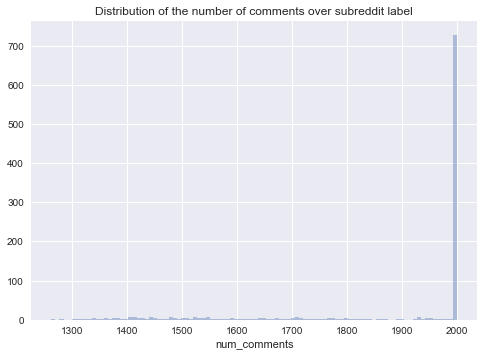

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

subs = data.loc[:,'subreddit'].drop_duplicates()

# Slice dataframe along those subreddit keywords, save the length of the slice in a dict
subsize = {}
for subreddit in subs:
    subsize[subreddit] = len(data[data['subreddit']==subreddit].index)
    
# Sort the dict and store in a dataframe
sizes = pd.DataFrame(np.array([list(map(int,(sorted(list(subsize.values()))))),
                       sorted(subsize, key=lambda x: (subsize[x], x))]).T,
                     columns=('num_comments','subreddit'))

print("There are {} comments across {} subreddits.".format(sum(sizes['num_comments'].astype(int)),len(subs)))
print()

# Print subreddits with fewest and greatest numbers of comments
print(sizes.iloc[pd.np.r_[:5, -5:0]])

sns.distplot(sizes['num_comments'].astype(int), kde=False, hist=True, bins=100);
plt.title("Distribution of the number of comments over subreddit label")
plt.show()


## Preprocessing Steps

### Remove top non-English-language subreddits
These were discovered by hand after filtering non-English characters. In production, this process should be automated.

In [3]:
data = data[data['subreddit'] != 'newsokur']
data = data[data['subreddit'] != 'Womad']


### Remove deleted comments
When a comment with children is removed from reddit, it is replaced with one of the dummy comments "[deleted]" or "[removed]". While the proportion of such removals to the comment section as a whole may be an intriguing feature, we do not explore it here.

In [4]:
deleteds = data.body=='[deleted]'
removeds = data.body=='[removed]'
print('{:.2f}% of the comments were deleted or removed before they could be archived.'.format(
    100*(sum(deleteds)+sum(removeds))/len(data.index)))
data = data[~deleteds]
data = data[~removeds]
print('These have been removed from the data.')
print()


3.85% of the comments were deleted or removed before they could be archived.


C:\Users\sfzba\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


These have been removed from the data.



### Remove markdown and non-english characters
Reddit has a basic markdown syntax (https://www.reddit.com/r/reddit.com/comments/6ewgt/reddit_markdown_primer_or_how_do_you_do_all_that/c03nik6/). These symbols and more are removed from the comments.

In [5]:
import re

# formatting markdown
md = re.compile(r"""
                [~#_`\*\+\^=>]+ # common markdown formatting symbols
                |&gt;+          # indent ">" is stored improperly sometimes
                """, re.VERBOSE)
# link markdown
lk = re.compile(r"""(\[(.*?)\])?\(.*?\)| # usual markdown links
                \/[ur]\/(\S+)            # reddit-internal links
                """, re.VERBOSE)
# currency marks
dl = re.compile(r'\$(\d*)') # dollar sign
br = re.compile(r'£(\d*)')  # pound sign
eu = re.compile(r'€(\d*)')  # euro sign
# percent sign
pc = re.compile(r'(\d*)%')
# ampersand
am = re.compile(r'&amp;|&')
# enforce ASCII alphanumerics (+é) and common punctuation
en = re.compile(r'[^\w\s,.:;\-\'\"\[\]\(\)!\?\/\\é]+', re.ASCII)

def preprocess(text):
    text = md.sub(r"", text)
    text = lk.sub(r" \2\3 ", text)
    text = dl.sub(r'\1 dollars', text)
    text = br.sub(r'\1 pounds', text)
    text = eu.sub(r'\1 euros', text)
    text = pc.sub(r'\1 percent', text)
    text = am.sub(r' and ', text)
    text = en.sub(r' ', text)
    return text    

%time data['body'] = data['body'].astype('unicode').apply(preprocess)


Wall time: 1min 47s


### Remove blank comments
After the above processing steps, some comments may be blank.

In [6]:
blanks = data['body'].str.contains(r'^[\s]*$')
print('{:.2f}% of the comments were blank after preprocessing.'.format(100*sum(blanks)/len(data.index)))
data = data[~blanks]
print('These have been removed from the data.')
print()


0.17% of the comments were blank after preprocessing.
These have been removed from the data.



## Save dataframe to use in later evaluation

In [ ]:
data.to_pickle('data/prepped.pkl')

## Post-preprocessing Visualizations

### Review class sizes
It would be better to write this as a function, rather than write out the code twice.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

subsize = {}
subs = data.loc[:,'subreddit'].drop_duplicates()
for subreddit in subs:
    subsize[subreddit] = len(data[data['subreddit']==subreddit].index)
sizes = pd.DataFrame(np.array([sorted(list(subsize.values())),
                       sorted(subsize, key=lambda x: (subsize[x], x))]).T,
                     columns=('num_comments','subreddit'))

print("There are {} comments across {} subreddits.".format(sum(sizes['num_comments'].astype(int)),len(subs)))
print()

print(sizes.iloc[pd.np.r_[:5, -5:0]])

sns.distplot(sizes['num_comments'].astype(int), kde=False, hist=True, bins=100);
plt.title("Distribution of the number of comments over subreddit label")
plt.show()


### Wordclouds from random subreddits
Again, these wordcloud generations should be function calls.

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

wc = WordCloud(background_color="white", max_words=100)
le = LabelEncoder()
y = le.fit_transform(data.subreddit)

nsubs  = 6
nwords = 10

for i in np.random.randint(len(data.loc[:,'subreddit'].drop_duplicates())+1, size=nsubs):
    wc.generate(data.body[y==i].str.cat(sep=' ')) # tokenized by r"\w[\w']+"
    
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title('Wordcloud from /r/{}'.format(le.inverse_transform(i)))
    plt.show()
    
    words = []
    freqs = []
    for word in wc.words_:
        if wc.words_[word]!=0:
            words.append(word)
            freqs.append(wc.words_[word])
    x = range(nwords,0,-1)
    plt.barh(x,freqs[:nwords])
    plt.yticks(x, np.asarray(words[:nwords]))
    plt.title('Word Frequency in /r/{}'.format(le.inverse_transform(i)))
    plt.show()
    

### Wordclouds from all subreddits

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

wc_all = WordCloud(background_color="white", max_words=100)

wc_all.generate(data.body.str.cat(sep=' ')) # tokenized by r"\w[\w']+"

plt.imshow(wc_all, interpolation="bilinear")
plt.axis("off")
plt.title('Wordcloud from all subreddits')
plt.show()

words_all = []
freqs_all = []
for word in wc_all.words_:
    if wc_all.words_[word]!=0:
        words_all.append(word)
        freqs_all.append(wc_all.words_[word])
x = range(nwords,0,-1)
plt.barh(x,freqs_all[:nwords])
plt.yticks(x, np.asarray(words_all[:nwords]))
plt.title('Word Frequency in all subreddits')
plt.show()
    

### Wordclouds from /r/gaming and /r/politics

In [ ]:
stops = wc_all.stopwords
stops.update(words_all)
subs  = ['gaming','politics']
nwords = 10

for sub in subs:
    wc = WordCloud(background_color="white", max_words=20,stopwords=stops)
    wc.generate(data.body[data.subreddit==sub].str.cat(sep=' ')) # tokenized by r"\w[\w']+"
    
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title('Wordcloud from /r/{}'.format(sub))
    plt.show()
    
    words = []
    freqs = []
    for word in wc.words_:
        if wc.words_[word]!=0:
            words.append(word)
            freqs.append(wc.words_[word])
    x = range(nwords,0,-1)
    plt.barh(x,freqs[:nwords])
    plt.yticks(x, np.asarray(words[:nwords]))
    plt.title('Word frequencies in /r/{}'.format(sub))
    plt.show()

## Vectorize comments
Once the comments are cleaned up, they may be vectorized. The sklearn CountVectorizer is used, but with a custom tokenizer.

### Custom tokenizer (NLTK)
The text is stemmed (so conjugations of words are counted together) using the Natural Language Tool Kit (NLTK) WordNet lemmatizer and a modified NLTK part-of-speech tagger. The NLTK stopwords are discarded.

In [ ]:
from nltk import word_tokenize
from nltk import pos_tag
from nltk import wordnet
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        self.stop = set(stopwords.words('english'))
    def __call__(self, doc):
        return [t.lower() for t in 
                [self.wnl.lemmatize(t,self.get_wordnet_pos(t)) for t, pos in pos_tag(word_tokenize(doc))] 
                if re.match("^[a-zA-Z0-9_]*$", t) and t not in self.stop]
    def get_wordnet_pos(self, treebank_tag):
        '''https://stackoverflow.com/questions/15586721/, with default noun'''
        if treebank_tag.startswith('J'):
            return wordnet.wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.wordnet.ADV
        else:
            return wordnet.NOUN


### Create term count matrix
This is the most time-consuming step, taking five to six hours. 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

print("Extracting term counts...")
count_vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), 
                                stop_words='english',
                                max_df=0.5, # Do not include words if they are in over half the comments
                                min_df=2,   # Do not include words if they are in only one comment
                                )
t0 = time()
cts = count_vectorizer.fit_transform(data['body'].astype('unicode'))
print("done in %0.3fs." % (time() - t0))
print()

# Save results for quick iteration
import pickle
with open('data/feature_names.pkl', 'wb') as fp:
    pickle.dump(count_vectorizer.get_feature_names(), fp)
from scipy.sparse import save_npz
save_npz('data/term_counts.npz', cts)


# #  Alternative to above text block:
# from scipy.sparse import load_npz
# cts = load_npz('data/term_counts.npz')


### Create frequency matrices
The term frequency and inverse document frequency matrices are computed from the term count matrix.

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

print("Extracting term frequency features...")

# Create tf matrix
print("tf...")
tf_transformer = TfidfTransformer(norm='l2', use_idf=False)
t0 = time()
tf = tf_transformer.fit_transform(cts)
print("done in %0.3fs." % (time() - t0))
print()

# Create tf/idf matrix
print("tfidf...")
tfidf_transformer = TfidfTransformer(norm='l2', use_idf=True)
t0 = time()
tfidf = tfidf_transformer.fit_transform(cts)
print("done in %0.3fs." % (time() - t0))
print()


# Save results for quick iteration
from scipy.sparse import save_npz
save_npz('data/tf.npz', tf)
save_npz('data/tfidf.npz', tfidf)


#  Alternative to above text block:
# from scipy.sparse import load_npz
# tf = load_npz('data/tf.npz')
# tfidf = load_npz('data/tfidf.npz')


## Validate saved files

In [ ]:
from scipy.sparse import load_npz
import pickle

print("Importing data...")
t0 = time()
data_val = pd.read_pickle('data/prepped.pkl')
with open('data/feature_names.pkl', 'rb') as fp:
    feature_names_val = pickle.load(fp)
cts_val = load_npz('data/term_counts.npz')
tf_val = load_npz('data/tf.npz')
tfidf_val = load_npz('data/tfidf.npz')
print("done in %0.3fs" % (time()-t0))

print()

n_comments = data_val.shape[0]
print("There are %0.f comments." % n_comments)
if cts_val.shape[0] != n_comments: print("Count matrix has too few rows: %0.0f" % cts_val.shape[0])
if tf_val.shape[0] != n_comments: print("TF matrix has too few rows: %0.0f" % tf_val.shape[0])
if tfidf_val.shape[0] != n_comments: print("TF/IDF matrix has too few rows: %0.0f" % tfidf_val.shape[0])

print()

n_words = len(feature_names_val)
print("There are %0.f words counted." % n_words)
if cts_val.shape[1] != n_words: print("Count matrix has too few columns: %0.0f" % cts_val.shape[1])
if tf_val.shape[1] != n_words: print("TF matrix has too few columns: %0.0f" % tf_val.shape[1])
if tfidf_val.shape[1] != n_words: print("TF/IDF matrix has too few columns: %0.0f" % tfidf_val.shape[1])


## Repeat above processing with agglomeration
Combine all comments from each subreddit into a single string, then repeat the vectorization process.

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), 
                                stop_words='english',
                                max_df=0.5, # Do not include words if they are in over half the comments
                                min_df=2,   # Do not include words if they are in only one comment
                                )
tf_transformer = TfidfTransformer(norm='l2', use_idf=False)
tfidf_transformer = TfidfTransformer(norm='l2', use_idf=True)

print("Combining subreddit comments into a single string..."
t0 = time()
data_comments = data
data = pd.DataFrame(columns=['body','subreddit'])
for idx, sub in enumerate(data_comments.loc[:,'subreddit'].drop_duplicates()):
    data.loc[idx] = [data_comments.body[
        data_comments['subreddit']==sub].astype('unicode').str.cat(sep=' '), sub]
print("done in %.3fs." % (time()-t0))

print("Extracting term counts...")
t0 = time()
cts = count_vectorizer.fit_transform(data['body'].astype('unicode'))
print("done in %0.3fs." % (time() - t0))
print()

print("Extracting term frequency features...")

print("tf...")
t0 = time()
tf = tf_transformer.fit_transform(cts)
print("done in %0.3fs." % (time() - t0))
print()

print("tfidf...")
t0 = time()
tfidf = tfidf_transformer.fit_transform(cts)
print("done in %0.3fs." % (time() - t0))
print()


# Save results for quick iteration
data.to_pickle('data/prepped_sub.pkl')
with open('data/feature_names_sub.pkl', 'wb') as fp:
    pickle.dump(count_vectorizer.get_feature_names(), fp)
save_npz('data/term_counts_sub.npz', cts)
save_npz('data/tf_sub.npz', tf)
save_npz('data/tfidf_sub.npz', tfidf)


In [ ]:
data.to_pickle('data/prepped_sub.pkl')
